In [1]:
import matplotlib.pyplot as plt
import os, re, pickle
import scipy.io
import numpy as np
from collections import defaultdict

import pandas as pd

In [2]:
layers = ['model_1_act', 'model_2_cv1_act', 'model_2_cv2_act', 'model_2_m_0_cv1_act', 'model_2_m_0_cv2_act', 'model_2_cv3_act', 'model_3_act', 'model_4_cv1_act', 'model_4_cv2_act', 'model_4_m_0_cv1_act', 'model_4_m_0_cv2_act', 'model_4_m_1_cv1_act', 'model_4_m_1_cv2_act', 'model_4_cv3_act', 'model_5_act', 'model_6_cv1_act', 'model_6_cv2_act', 'model_6_m_0_cv1_act', 'model_6_m_0_cv2_act', 'model_6_m_1_cv1_act', 'model_6_m_1_cv2_act', 'model_6_m_2_cv1_act', 'model_6_m_2_cv2_act', 'model_6_cv3_act', 'model_7_act', 'model_8_cv1_act', 'model_8_cv2_act', 'model_8_m_0_cv1_act', 'model_8_m_0_cv2_act', 'model_8_cv3_act', 'model_9_cv1_act', 'model_9_cv2_act', 'model_10_act', 'model_13_cv1_act', 'model_13_cv2_act', 'model_13_m_0_cv1_act', 'model_13_m_0_cv2_act', 'model_13_cv3_act', 'model_14_act', 'model_17_cv1_act', 'model_17_cv2_act', 'model_17_m_0_cv1_act', 'model_17_m_0_cv2_act', 'model_17_cv3_act']

In [7]:
color_codes = {
    'bilinear' : "tab:blue",
    'optimized' : "tab:orange",
}

## Valid Area = BBoxes Total
normalized by the first step (confidence on the intact image)

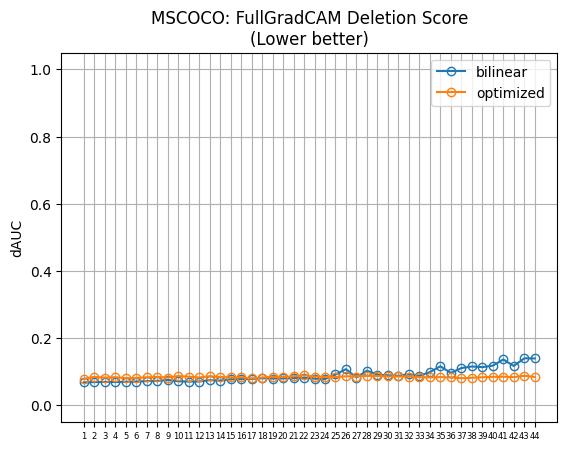

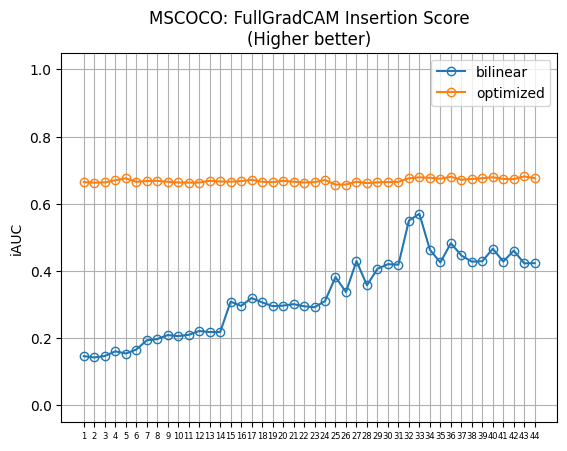

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


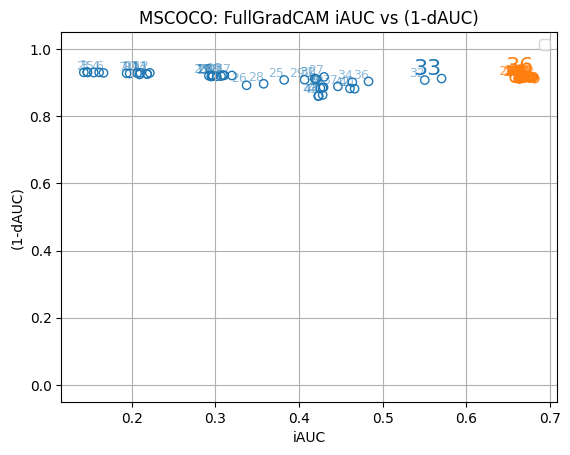

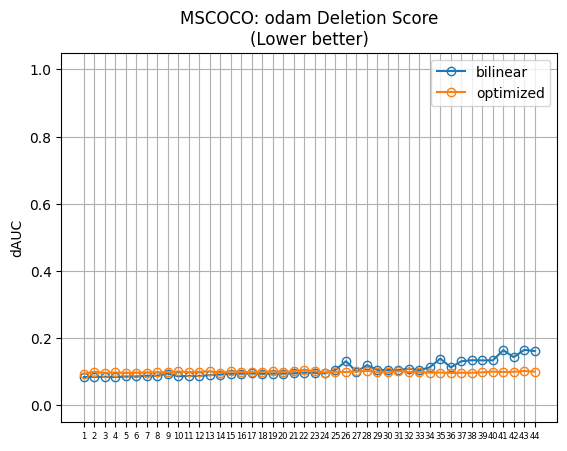

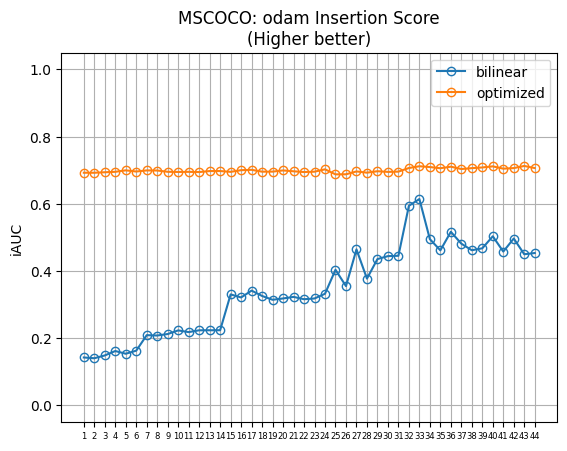

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


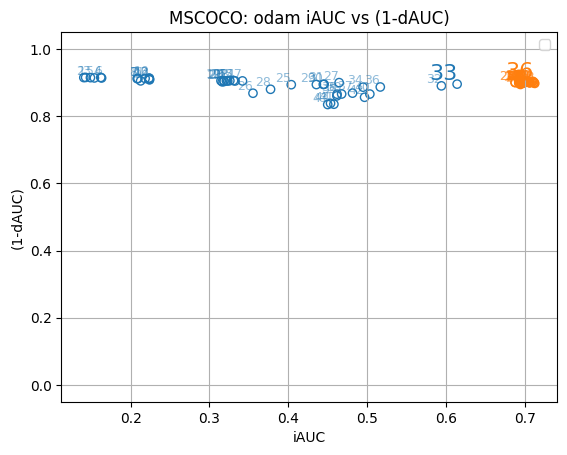

In [8]:
skip_images = ['book_472678',"baseball glove_515982","toothbrush_160666","potted plant_473219","bench_350607","truck_295420","toaster_232348","kite_405279","toothbrush_218439","snowboard_425906","car_227511","traffic light_453841","hair drier_239041","hair drier_178028","toaster_453302","mouse_513688","spoon_88040","scissors_340930","handbag_383842"]

for is_act in ['']:

    sigma_factors = ['bilinear','optimized']
    xai_methods = ['fullgradcamraw','odam']

    dAUC = {}
    iAUC = {}

    for xai_method in xai_methods:

        root_dir = '/opt/jinhanz/results/optimize_faithfulness/mscoco'

        dAUC[xai_method] = defaultdict(defaultdict)
        iAUC[xai_method] = defaultdict(defaultdict)

        for sigma_factor in sigma_factors:
            if sigma_factor == 'bilinear':
                root = f"/opt/jinhanz/results/perturb_pixel_whole/mscoco/xai_saliency_maps_yolov5s{is_act}_{sigma_factor}/{xai_method}"
            else:
                root = f"/opt/jinhanz/results/optimize_faithfulness/mscoco/xai_saliency_maps_yolov5s/{xai_method}"

            for layer in layers:
                path = os.path.join(root,f"{layer}.pickle")
                mat = pickle.load(open(path,'rb'))
                all_imgs = mat['all_imgs']
                valid_idx = [idx for idx, img_name in enumerate(all_imgs) if img_name not in skip_images]                
                intact_score = 1 #mat['meanConf_deletionAI'][0,:]
                dAUC[xai_method][sigma_factor][layer] = (mat['meanConf_deletionAI'][:,valid_idx].mean(axis=0) / intact_score).mean()
                iAUC[xai_method][sigma_factor][layer] = (mat['meanConf_insertionAI'][:,valid_idx].mean(axis=0)  / intact_score).mean()
    
    for xai_method in xai_methods:
        plt.figure()
        plt.grid()
        for sigma_factor in sigma_factors:
            legend = sigma_factor
            plt.plot(range(len(layers)), dAUC[xai_method][sigma_factor].values(),color=color_codes[sigma_factor],marker='o',fillstyle='none',label=legend)
        plt.xticks(range(len(layers)), [f"{i+1}" for i, name in enumerate(dAUC[xai_method][sigma_factor].keys())],fontsize=6)
        plt.title(f"MSCOCO: {xai_method.replace('fullgradcamraw','FullGradCAM')} Deletion Score\n(Lower better)")
        plt.ylim([-0.05,1.05])
        plt.ylabel("dAUC")
        plt.legend()
        plt.show()

        plt.figure()
        plt.grid()
        for sigma_factor in sigma_factors:
            legend = sigma_factor
            plt.plot(range(len(layers)), iAUC[xai_method][sigma_factor].values(),color=color_codes[sigma_factor],marker='o',fillstyle='none',label=legend)
        plt.xticks(range(len(layers)), [f"{i+1}" for i, name in enumerate(iAUC[xai_method][sigma_factor].keys())],fontsize=6)
        plt.title(f"MSCOCO: {xai_method.replace('fullgradcamraw','FullGradCAM')} Insertion Score\n(Higher better)")
        plt.ylim([-0.05,1.05])
        plt.ylabel("iAUC")
        plt.legend()
        plt.show()

        plt.figure()
        plt.grid()
        for sigma_factor in sigma_factors:
            legend = sigma_factor
            one_minus_dAUC = np.asarray([1 - d for d in dAUC[xai_method][sigma_factor].values()])
            iAUC_values = np.asarray([i for i in iAUC[xai_method][sigma_factor].values()])
            plt.scatter(iAUC_values, one_minus_dAUC, facecolors='none', edgecolors=color_codes[sigma_factor], marker='o')
            max_index = np.argmax(iAUC_values+one_minus_dAUC)
            for i, (x, y) in enumerate(zip(iAUC_values, one_minus_dAUC)):
                if i == max_index:
                    plt.text(x, y, str(i+1), fontsize=16, ha='right', va='bottom', color=color_codes[sigma_factor])
                else:
                    plt.text(x, y, str(i+1), fontsize=9, ha='right', va='bottom', color=color_codes[sigma_factor],alpha=0.5)
        plt.title(f"MSCOCO: {xai_method.replace('fullgradcamraw','FullGradCAM')} iAUC vs (1-dAUC)")
        plt.ylim([-0.05,1.05])
        plt.ylabel("(1-dAUC)")
        plt.xlabel("iAUC")
        plt.legend()
        plt.show()